In [1]:
!pip install wandb
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=7f8e6120f13c66699855c6c864a827ab27578a75352c309290b61ad8957935f1
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: fi

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import wandb
from wandb.keras import WandbCallback

import medmnist
from medmnist import INFO

In [4]:
run = wandb.init(project='Slide Prediction', entity='tenzinphuntsho', name='bhutan_landslide_data')

wandb: Currently logged in as: tenzinphuntsho. Use `wandb login --relogin` to force relogin


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load data into a pandas DataFrame
df = pd.read_csv('drive/MyDrive/GovTech/FullFunctioning/bhutan_landslide_data.csv')

In [7]:
df

,FID,Type,Code,Lithology,Altitude,Slope,Total curvature,Aspect,Distance to road,Distance to stream,Slope length,TWI,STI
0,0,slide,1,1,1,2,1,7,1,5,2,4,1
1,1,slide,1,1,1,3,1,4,2,2,2,5,1
2,2,slide,1,1,1,2,3,7,1,1,1,3,0
3,3,slide,1,1,1,3,1,10,1,2,2,4,0
4,4,slide,1,1,1,3,1,10,1,4,3,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,1216,slide,1,5,4,2,1,7,1,1,2,5,1
1217,1217,slide,1,5,4,2,2,8,1,1,2,1,0
1218,1218,slide,1,5,5,3,2,8,1,5,2,4,0
1219,1219,slide,1,5,4,2,3,7,1,2,1,0,0


In [8]:
df = df[df.columns[2:]]
df

,Code,Lithology,Altitude,Slope,Total curvature,Aspect,Distance to road,Distance to stream,Slope length,TWI,STI
0,1,1,1,2,1,7,1,5,2,4,1
1,1,1,1,3,1,4,2,2,2,5,1
2,1,1,1,2,3,7,1,1,1,3,0
3,1,1,1,3,1,10,1,2,2,4,0
4,1,1,1,3,1,10,1,4,3,5,0
...,...,...,...,...,...,...,...,...,...,...,...
1216,1,5,4,2,1,7,1,1,2,5,1
1217,1,5,4,2,2,8,1,1,2,1,0
1218,1,5,5,3,2,8,1,5,2,4,0
1219,1,5,4,2,3,7,1,2,1,0,0


Rearrange columns

In [9]:
categorical_variables = ['Lithology', 'Altitude', 'Slope', 'Total curvature',
       'Distance to road', 'Distance to stream', 'Slope length', 'TWI', 'STI','Code']
non_categorical_variables = list(set(df.columns) - set(categorical_variables))

# Re-ordering columns to have non-categorical varaibles first
order = non_categorical_variables + categorical_variables
df = df[order]

In [10]:
df

,Aspect,Lithology,Altitude,Slope,Total curvature,Distance to road,Distance to stream,Slope length,TWI,STI,Code
0,7,1,1,2,1,1,5,2,4,1,1
1,4,1,1,3,1,2,2,2,5,1,1
2,7,1,1,2,3,1,1,1,3,0,1
3,10,1,1,3,1,1,2,2,4,0,1
4,10,1,1,3,1,1,4,3,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1216,7,5,4,2,1,1,1,2,5,1,1
1217,8,5,4,2,2,1,1,2,1,0,1
1218,8,5,5,3,2,1,5,2,4,0,1
1219,7,5,4,2,3,1,2,1,0,0,1


Calculate information gain (IG)

In [11]:
features = df.columns[:-1]

# Separating out the features
X = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['Code']].values

In [12]:
features

Index(['Aspect', 'Lithology', 'Altitude', 'Slope', 'Total curvature',
       'Distance to road', 'Distance to stream', 'Slope length', 'TWI', 'STI'],
      dtype='object')

In [13]:
from sklearn.feature_selection import mutual_info_classif

res = dict(zip(features,
               mutual_info_classif(X, y.ravel(), discrete_features=[-1, -2, -3, -4])
               ))

In [14]:
res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
res

{'Distance to road': 0.21466494496854915,
 'Altitude': 0.12092424693841108,
 'Distance to stream': 0.00812757988929078,
 'Lithology': 0.007565763774922241,
 'Slope length': 0.0037811561614317767,
 'TWI': 0.0029604814410724017,
 'STI': 0.002436377041966622,
 'Aspect': 0.0,
 'Slope': 0.0,
 'Total curvature': 0.0}

One hot encode categorical variables

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Add numerical feature names to final feature name list
final_feature_names = []
final_feature_names += non_categorical_variables

# List of categorical feature names
categorical_features = ['Lithology', 'Altitude', 'Slope', 'Total curvature',
       'Distance to road', 'Distance to stream', 'Slope length', 'TWI', 'STI']

# Copy numerical features
data = df[non_categorical_variables]

# Copy one-hot encoded categorical features
for i in categorical_features:
    encoded = OneHotEncoder(sparse=False).fit_transform(df[i].values.reshape(df.shape[0],1))
    cols = [i+'_'+str(j) for j in range (1, encoded.shape[1]+1)]
    data = pd.concat([data, pd.DataFrame(encoded, columns=cols)], axis = 1)

# Copy labels
data = pd.concat([data, df[['Code']]], axis = 1)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

In [16]:
data

,Aspect,Lithology_1,Lithology_2,Lithology_3,Lithology_4,Lithology_5,Lithology_6,Altitude_1,Altitude_2,Altitude_3,...,TWI_4,TWI_5,TWI_6,TWI_7,STI_1,STI_2,STI_3,STI_4,STI_5,Code
0,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,10,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,10,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1217,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1218,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1219,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


Feature scaling


In [17]:
from sklearn.preprocessing import StandardScaler

# Stan
features = data.columns[:-1]

# Separating out the features
X = data.loc[:, features].values

# Separating out the target
y = data.loc[:,['Code']].values

X = StandardScaler().fit_transform(X)

In [18]:
X.shape

(1221, 53)

Principal Component Analysis

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [20]:
finalDf = pd.concat([principalDf, data[['Code']]], axis = 1)

In [21]:
finalDf

,principal component 1,principal component 2,Code
0,-2.665631,-0.743084,1
1,-1.846311,-1.741905,1
2,-2.562725,2.290298,1
3,-2.773802,-2.013929,1
4,-2.573325,-1.834164,1
...,...,...,...
1216,0.374624,-1.101143,1
1217,0.615717,1.076620,1
1218,0.363825,-0.860968,1
1219,0.439425,2.723340,1


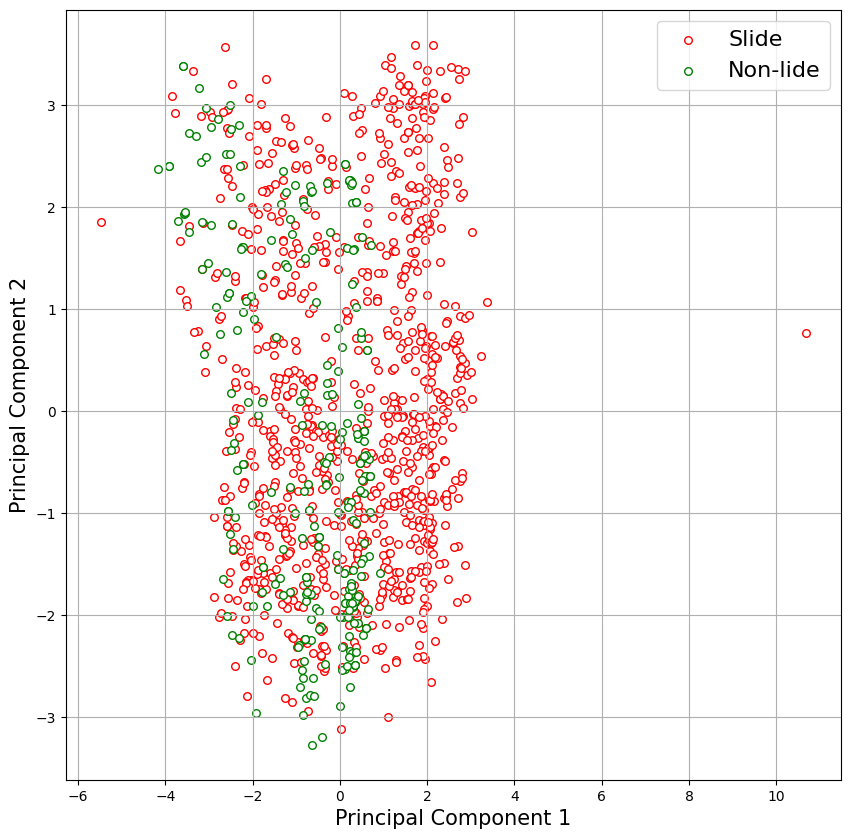

In [22]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = 'white',
#                c = color,
               edgecolors = color,
               s = 30,
#                alpha = 0.25
              )
ax.legend(['Slide','Non-lide'], fontsize =16)
ax.grid()
plt.savefig(os.path.join('drive/MyDrive/GovTech/FullFunctioning/figures_wandb','pca.png'), dpi = 300)

In [23]:
# Log the figure to Weight and Bias
wandb.log({'scatter_plot': wandb.Image(fig)})
wandb.finish()

Splitting dataset for training and testing

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

Machine Learning Algorithms

In [25]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

Logistic Regression

Hyperparameter(s):


*   C (inverse of regularization strength)

In [26]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

Hyperparameter optimization

In [27]:
run = wandb.init(project='Slide Prediction', entity='tenzinphuntsho', name='Logistic Regression')

model = LogisticRegression(random_state=0, solver = 'liblinear')

param_grid={'C':np.logspace(-3,3,7), # inverse of regularization strength
     }

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

C = grid.best_estimator_.C

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.8633398564905415
Best hyperparameters: {'C': 0.01}


Train on opmtimal hyperparameters

In [28]:
lr = LogisticRegression(random_state =0, solver = 'liblinear', C=C).fit(X_train,y_train.ravel())

Get predictions and probabilities on test set

In [29]:
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)

Performance metrics

In [30]:

lr_conf_mat = confusion_matrix(y_test, lr_pred)
lr_acc = accuracy_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_proba[:,1])

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba[:,1])
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_proba[:,1])

lr_cls_precision, lr_cls_recall, lr_cls_f1, _ = precision_recall_fscore_support(y_test, lr_pred, average=None, labels=[0,1])
print('Logistic Regression:')
print('\nConfusion matrix:\n',lr_conf_mat,'\n')
print('Accuracy:',lr_acc)
print('ROC AUC=%.4f' % (lr_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (lr_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (lr_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (lr_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (lr_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (lr_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (lr_cls_f1[1]))
wandb.log({'Accuracy':lr_acc,'ROC AUC': lr_roc_auc, 'Precision on (Landslide = 0)': lr_cls_precision[0], 'Recall on (Landslide = 0)': lr_cls_recall[0], 'F1 on (Landslide = 0)': lr_cls_f1[0], 'Precision on (Landslide = 1)': lr_cls_precision[1], 'Recall on (Landslide = 1)': lr_cls_recall[1], 'F1 on (Landslide = 1)': lr_cls_f1[1] })

Logistic Regression:

Confusion matrix:
 [[ 87  20]
 [ 42 340]] 

Accuracy: 0.8732106339468303
ROC AUC=0.9364
Precision on (Landslide = 0) = 0.6744 
Recall on (Landslide = 0) = 0.8131 
F1 on (Landslide = 0) = 0.7373
Precision on (Landslide = 1) = 0.9444 
Recall on (Landslide = 1) = 0.8901 
F1 on (Landslide = 1) = 0.9164 


Support Vector Machine

Hyperparameter(s):

*   C (inverse of regularization strength)
*   kernel (Specifies kernel type from, ‘poly’, ‘rbf’, ‘sigmoid’)
*   Gamma (kernel coefficient for 'rbf', 'poly' and 'sigmoid'

Hyperparameter optimization

In [35]:
run = wandb.init(project='Slide Prediction', entity='tenzinphuntsho', name='Support Vector Machine')

model = SVC(random_state=0, probability=True)


param_grid={'C':np.logspace(-3,3,7),
            'kernel': ['poly', 'rbf', 'sigmoid'],
          'gamma': [0.001, 0.01, 1],
           }
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

C = grid.best_estimator_.C
gamma = grid.best_estimator_.gamma
kernel = grid.best_estimator_.kernel

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Accuracy,▁
F1 on (Landslide = 0),▁
F1 on (Landslide = 1),▁
Precision on (Landslide = 0),▁
Precision on (Landslide = 1),▁
ROC AUC,▁
Recall on (Landslide = 0),▁
Recall on (Landslide = 1),▁
Accuracy,0.90593
F1 on (Landslide = 0),0.79279
F1 on (Landslide = 1),0.93915


Best score: 0.8879787531450936
Best hyperparameters: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


Train on opmtimal hyperparameters

In [36]:
svm = SVC(random_state =0, probability = True, C=C,  gamma =gamma, kernel = kernel).fit(X_train,y_train.ravel())

Get predictions and probabilities on test set

In [37]:
svm_pred = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)

Performance metrics

In [38]:
svm_conf_mat = confusion_matrix(y_test, svm_pred)
svm_acc = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_proba[:,1])

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba[:,1])
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_proba[:,1])

svm_cls_precision, svm_cls_recall, svm_cls_f1, _ = precision_recall_fscore_support(y_test, svm_pred, average=None, labels=[0,1])
print('Support Vector Machine :')
print('\nConfusion matrix:\n',svm_conf_mat,'\n')
print('Accuracy:',svm_acc)
print('ROC AUC=%.4f' % (svm_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (svm_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (svm_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (svm_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (svm_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (svm_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (svm_cls_f1[1]))
wandb.log({'Accuracy':svm_acc,'ROC AUC': svm_roc_auc, 'Precision on (Landslide = 0)': svm_cls_precision[0], 'Recall on (Landslide = 0)': svm_cls_recall[0], 'F1 on (Landslide = 0)': svm_cls_f1[0], 'Precision on (Landslide = 1)': svm_cls_precision[1], 'Recall on (Landslide = 1)': svm_cls_recall[1], 'F1 on (Landslide = 1)': svm_cls_f1[1] })

Support Vector Machine :

Confusion matrix:
 [[ 88  19]
 [ 27 355]] 

Accuracy: 0.9059304703476483
ROC AUC=0.9513
Precision on (Landslide = 0) = 0.7652 
Recall on (Landslide = 0) = 0.8224 
F1 on (Landslide = 0) = 0.7928
Precision on (Landslide = 1) = 0.9492 
Recall on (Landslide = 1) = 0.9293 
F1 on (Landslide = 1) = 0.9392 


Random Forest

Hyperparameter(s):


*   n_estimators
*   max_features
*   max_depth
*   criterion

Hyperparameter optimization

In [39]:
run = wandb.init(project='Slide Prediction', entity='tenzinphuntsho', name='Random Forest')


model = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,30,2),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

n_estimators = grid.best_estimator_.n_estimators
criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Accuracy,▁
F1 on (Landslide = 0),▁
F1 on (Landslide = 1),▁
Precision on (Landslide = 0),▁
Precision on (Landslide = 1),▁
ROC AUC,▁
Recall on (Landslide = 0),▁
Recall on (Landslide = 1),▁
Accuracy,0.90593
F1 on (Landslide = 0),0.79279
F1 on (Landslide = 1),0.93915


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best score: 0.9071009225608051
Best hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 30}


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train on optimal hyperparameters

In [40]:
rf = RandomForestClassifier(random_state=0, criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators = n_estimators).fit(X_train, y_train.ravel())


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Get predictions and probabilities on test set



In [41]:
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

Performance metrics

In [42]:
rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_proba[:,1])

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:,1])
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_proba[:,1])

rf_cls_precision, rf_cls_recall, rf_cls_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average=None, labels=[0,1])

print('Random Forest :')
print('\nConfusion matrix:\n',rf_conf_mat,'\n')
print('Accuracy:',rf_acc)
print('ROC AUC=%.4f' % (rf_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (rf_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (rf_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (rf_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (rf_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (rf_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (rf_cls_f1[1]))
wandb.log({'Accuracy':lr_acc,'ROC AUC': rf_roc_auc, 'Precision on (Landslide = 0)': rf_cls_precision[0], 'Recall on (Landslide = 0)': rf_cls_recall[0], 'F1 on (Landslide = 0)': rf_cls_f1[0], 'Precision on (Landslide = 1)': rf_cls_precision[1], 'Recall on (Landslide = 1)': rf_cls_recall[1], 'F1 on (Landslide = 1)': rf_cls_f1[1] })

Random Forest :

Confusion matrix:
 [[ 91  16]
 [ 27 355]] 

Accuracy: 0.9120654396728016
ROC AUC=0.9632
Precision on (Landslide = 0) = 0.7712 
Recall on (Landslide = 0) = 0.8505 
F1 on (Landslide = 0) = 0.8089
Precision on (Landslide = 1) = 0.9569 
Recall on (Landslide = 1) = 0.9293 
F1 on (Landslide = 1) = 0.9429 


Export trained and tested models

In [43]:
import joblib

joblib.dump(lr, os.path.join('drive/MyDrive/GovTech/FullFunctioning/models_wandb','lr.pkl'), compress=9)
joblib.dump(svm, os.path.join('drive/MyDrive/GovTech/FullFunctioning/models_wandb','svm.pkl'), compress=9)
joblib.dump(rf, os.path.join('drive/MyDrive/GovTech/FullFunctioning/models_wandb','rf.pkl'), compress=9)

['drive/MyDrive/GovTech/FullFunctioning/models_wandb/rf.pkl']

Export performance metrics of models

In [44]:
perf_metr = pd.DataFrame(index = [
                        'Logistic Regression',
                        'Support Vector Machine',
                        'Random Forest',
                       ],
             columns = ['Accuracy', 
                        'ROC AUC', 
                        'Precision on Landlside=0', 
                        'Recall on Landlside=0', 
                        'F1-score on Landlside=0', 
                        'Precision on Landlside=1', 
                        'Recall on Landlside=1', 
                        'F1-score on Landlside=1']
            )

In [45]:
lr_perf_metr = pd.Series([lr_acc, lr_roc_auc, lr_cls_precision[0], lr_cls_recall[0], lr_cls_f1[0], lr_cls_precision[0],lr_cls_recall[0], lr_cls_f1[0]])
svm_perf_metr = pd.Series([svm_acc, svm_roc_auc, svm_cls_precision[0], svm_cls_recall[0], svm_cls_f1[0], svm_cls_precision[0],svm_cls_recall[0], svm_cls_f1[0]])
rf_perf_metr = pd.Series([rf_acc, rf_roc_auc, rf_cls_precision[0], rf_cls_recall[0], rf_cls_f1[0], rf_cls_precision[0],rf_cls_recall[0], rf_cls_f1[0]])

In [46]:
perf_metr.loc['Logistic Regression',:] = lr_perf_metr.values
perf_metr.loc[ 'Support Vector Machine',:] = svm_perf_metr.values
perf_metr.loc['Random Forest',:] = rf_perf_metr.values

In [47]:
perf_metr = perf_metr.astype(float).round(3)

In [48]:
perf_metr

,Accuracy,ROC AUC,Precision on Landlside=0,Recall on Landlside=0,F1-score on Landlside=0,Precision on Landlside=1,Recall on Landlside=1,F1-score on Landlside=1
Logistic Regression,0.873,0.936,0.674,0.813,0.737,0.674,0.813,0.737
Support Vector Machine,0.906,0.951,0.765,0.822,0.793,0.765,0.822,0.793
Random Forest,0.912,0.963,0.771,0.850,0.809,0.771,0.850,0.809


In [49]:
run = wandb.init(project='Slide Prediction', entity='tenzinphuntsho', name='Table_Comparation')

Accuracy,▁
F1 on (Landslide = 0),▁
F1 on (Landslide = 1),▁
Precision on (Landslide = 0),▁
Precision on (Landslide = 1),▁
ROC AUC,▁
Recall on (Landslide = 0),▁
Recall on (Landslide = 1),▁
Accuracy,0.87321
F1 on (Landslide = 0),0.80889
F1 on (Landslide = 1),0.9429


In [50]:
# Create a Weights and Biases table
table = wandb.Table(dataframe=perf_metr)

In [51]:
# Log the table to Weights and Biases
wandb.log({'Performance Matrix for three Model': table})

In [52]:
perf_metr.to_csv(os.path.join('performance_metrics.csv'))

ROC-AUC curves

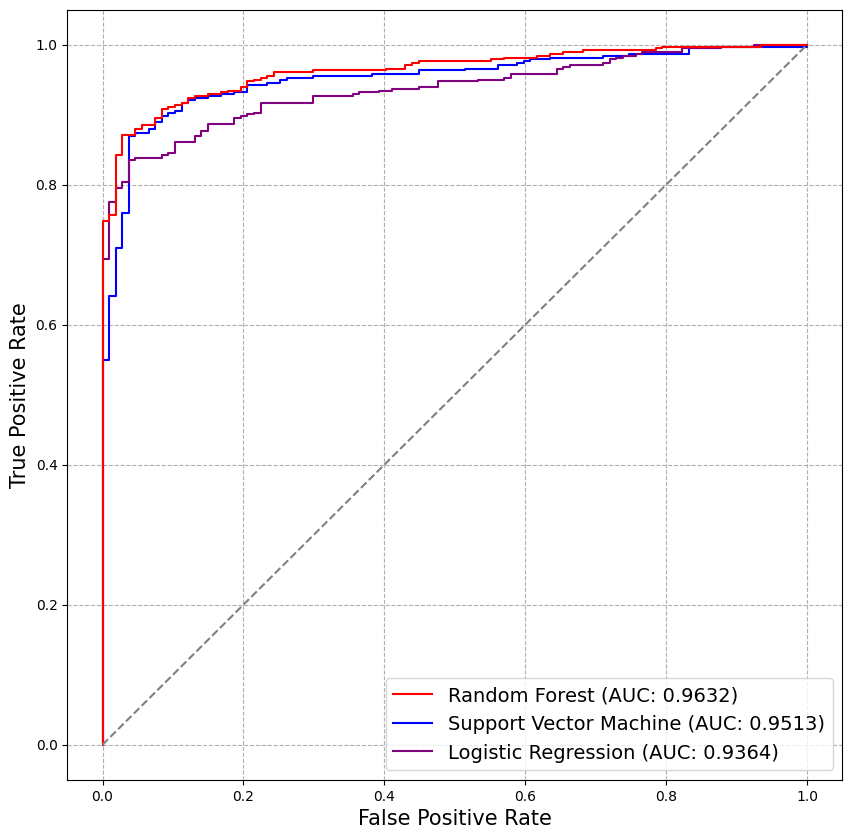

In [53]:
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba[:,1])
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba[:,1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:,1])

fig, ax = plt.subplots(1, figsize=(10,10))

# fig.figure(figsize=(10,10))

# plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(svm_fpr, svm_tpr,  color = 'blue', label='Support Vector Machine (AUC: ' + str(np.round(svm_roc_auc,4))+')')
ax.plot(lr_fpr, lr_tpr,  color = 'purple', label='Logistic Regression (AUC: ' + str(np.round(lr_roc_auc,4))+')')
ax.plot(rf_fpr, rf_tpr,  color = 'red', label='Random Forest (AUC: ' + str(np.round(rf_roc_auc,4))+')')
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')

# axis labels
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)

# show the legend
# plt.legend()

handles,labels = ax.get_legend_handles_labels()


handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]

ax.grid(linestyle='dashed')
ax.legend(handles,labels, fontsize=14)

plt.savefig(os.path.join('drive/MyDrive/GovTech/FullFunctioning/figures','roc-auc.png'), dpi = 300)
# show the plot
plt.show()

In [54]:
run = wandb.init(project='Slide Prediction', entity='tenzinphuntsho', name='ROC-AUC_curves_Comparation')

In [55]:
wandb.log({'scatter_plot': wandb.Image(ax)})
wandb.finish()